In [111]:
import numpy as np
import scipy.stats as ss

## Stochastic volatility model

- $X_1 \sim N(0, \sigma^2)$
- $X_t | X_{t-1} = x \sim N(\phi x, \sigma^2)$
- $Y_t | X_t = x \sim N(0, \beta^2 \exp(x))$

In [112]:
np.random.seed(1)

In [113]:
def f(x, beta):
  return(beta**2 * np.exp(x))

def w(x, y, beta):
  ww = ss.norm.pdf(x = y, loc = 0, scale = f(x,beta))
  return(ww)



In [126]:
T = 200
x = np.zeros(T)
y = np.zeros(T)
sigma = 0.16
beta = 0.64
phi = 1
x[0] = np.random.normal(loc=0, scale = sigma)
y[0] = np.random.normal(loc=0, scale = f(x[0], beta))
for t in range(1,T):
  x[t] = np.random.normal(phi*x[t-1], sigma)
  y[t] = np.random.normal(0, f(x[t], beta))



In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [128]:
dat = pd.DataFrame({"t": np.arange(T), "x": x, "y": y})


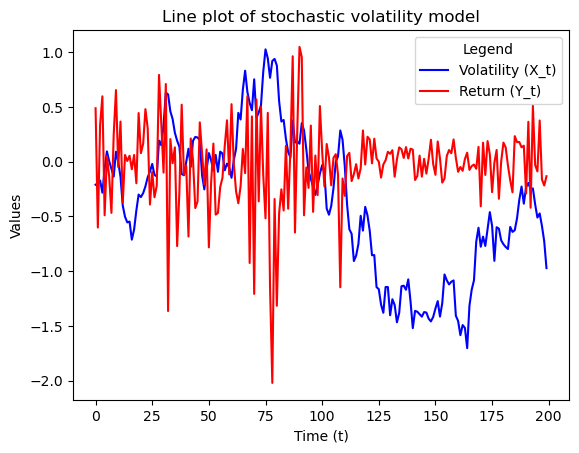

In [129]:
sns.lineplot(data = dat, x="t", y="x", label="Volatility (X_t)", color="blue")
sns.lineplot(data = dat, x="t", y="y", label="Return (Y_t)", color="red")
plt.title('Line plot of stochastic volatility model')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend(title='Legend')  # Add a legend with a title
plt.show()

## Implement SIS

For $t = 1, ..., T$, 

+ Proposal: $x_t^k \sim q_t$
+ Extend: $x_{1:t}^k = (x_{1:t-1}^k, x_t^k)$
+ Weighting: $w(x_{1:t}^k) = \frac{\gamma_t(x_{1:t}^k)}{\nu_t(x_{1:t}^k)}$

For hidden Markov model, the weight function is given by,

$$w(x_{1:t}) = w(x_{1:t-1}) \times \alpha(x_{1:t-1}, x_t).$$

When $q_t(x_t) = f(x_t | x_{t-1})$:

$$\alpha(x_{1:t-1}, x_t) = g(y_t | x_t).$$

In [130]:
num_samples = 10000
x_samples = np.zeros((num_samples,T))
weights = np.zeros((num_samples,T))

In [131]:
x_samples[:,0] = np.random.normal(loc=0, scale=sigma, size=num_samples)
weights[:,0] = w(x_samples[:,0], y[0], beta)

In [132]:
for t in range(1, T):
    x_samples[:,t] = np.random.normal(loc=x_samples[:,t-1], scale=sigma, size=num_samples)
    weights[:,t] = weights[:,t-1] * w(x_samples[:,t], y[t], beta)

## Weight degeneracy

+ Compute the normalized weights at each time $t = 1, ..., T$.
+ Plot histogram of weights.
    - Numerical stability issue! How do we resolve this?


In [133]:
norm_w = weights/weights.sum(0)

In [134]:
# Sum of weights is 0!
# How do we make the computation more numerically stable?
weights.sum(0)[T-1]

1.9129286238850585e-16

(array([9.999e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.09999993, 0.19999987, 0.2999998 , 0.39999973,
        0.49999967, 0.5999996 , 0.69999954, 0.79999947, 0.8999994 ,
        0.99999934]),
 <BarContainer object of 10 artists>)

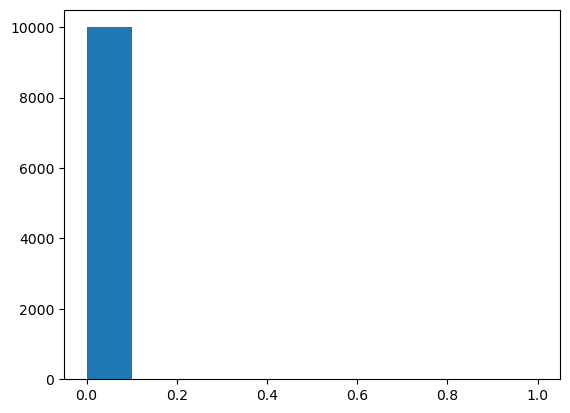

In [136]:
plt.hist(norm_w[:,T-1])

## Implement sequential Monte Carlo

For $t = 1, ..., T$, 

+ If $t > 1$:
  - $\bar{w}_t^k = w(x_{1:t}^k)/\sum_{k'} w(x_{1:t}^{k'})$
  - Sample $\tilde{x}_{t-1}^k \sim \text{Multinomial}(\bar{w}_{1:t-1}^1, ..., \bar{w}_{1:t-1}^K)$
+ Proposal: $x_t^k \sim q_t$
+ Extend: $x_{1:t}^k = (\tilde{x}_{1:t-1}^k, x_t^k)$
+ Weighting: $w(x_{1:t}^k) = \frac{\gamma_t(x_{1:t}^k)}{\nu_t(x_{1:t}^k)}$



In [137]:
x_samples[:,0] = np.random.normal(loc=0, scale=sigma, size=num_samples)
weights[:,0] = w(x_samples[:,0], y[0], beta)

for t in range(1, T):
    # resampling.
    norm_w = weights[:,t-1]/weights[:,t-1].sum()
    idxs = np.random.choice(np.arange(num_samples), size=num_samples, replace=True, p=norm_w)
    x_samples[:,t] = np.random.normal(loc=x_samples[idxs,t-1], scale=sigma, size=num_samples)
    weights[:,t] = w(x_samples[:,t], y[t], beta)

(array([3.000e+00, 3.000e+00, 1.500e+01, 2.500e+01, 5.300e+01, 1.050e+02,
        2.490e+02, 7.210e+02, 1.963e+03, 6.863e+03]),
 array([-4.14235365, -3.8190754 , -3.49579716, -3.17251891, -2.84924066,
        -2.52596241, -2.20268417, -1.87940592, -1.55612767, -1.23284943,
        -0.90957118]),
 <BarContainer object of 10 artists>)

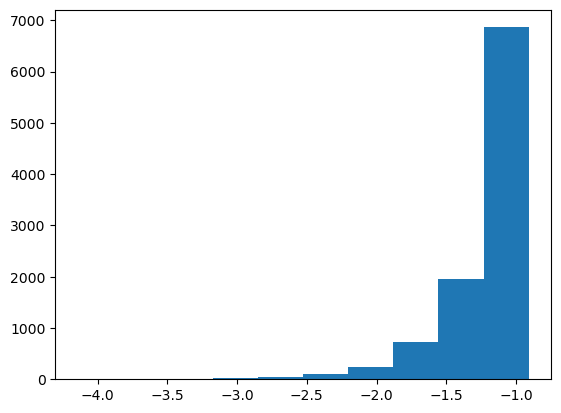

In [138]:
plt.hist(np.log(weights[:,1]))

(array([   3.,   14.,   31.,  126.,  310.,  740., 1428., 2252., 2682.,
        2414.]),
 array([-1.22908918, -1.04552288, -0.86195657, -0.67839027, -0.49482396,
        -0.31125766, -0.12769135,  0.05587496,  0.23944126,  0.42300757,
         0.60657387]),
 <BarContainer object of 10 artists>)

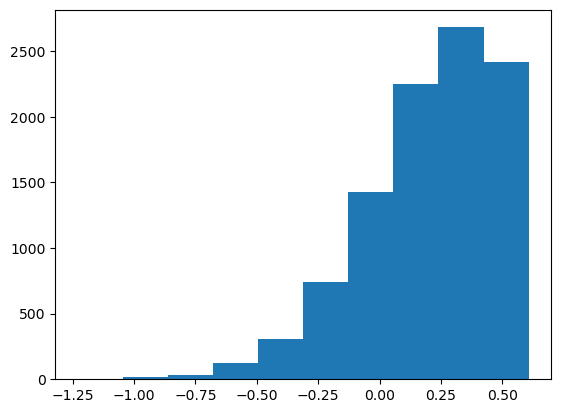

In [139]:
plt.hist(np.log(weights[:,T-1]))

## Exercises:

- Point estimation: weighted average.

- Compute the filtering distribution:

$$p(x_t | y_{1:t}) = \sum_{k} \bar{w}_t^k \delta_{x_t^k}(x_t).$$

- Perform kernel density estimation using the particles and the weights.

- Compute the coverage probability.

- Compute the prediction distribution and prediction interval:

$$p(x_{t+1} | y_{1:t}) = \sum_{k} p(x_{t+1} | x_t^k) \bar{w}_t^k \delta_{x_t^k}(x_t).$$


In [147]:
tt = 185
norm_w = weights[:,tt]/weights[:,tt].sum()
x_hat = np.sum(norm_w * x_samples[:,tt])
print(x_hat)
print(x[tt])

-0.6754866745601111
-0.6253753256340432


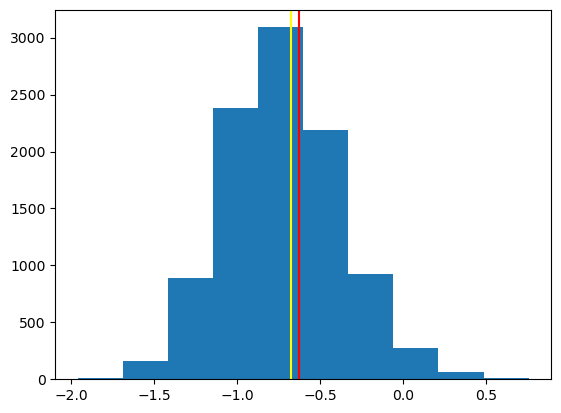

In [148]:

plt.hist(x_samples[:,tt])
plt.axvline(x=x[tt], color="red")
plt.axvline(x=x_hat, color="yellow")

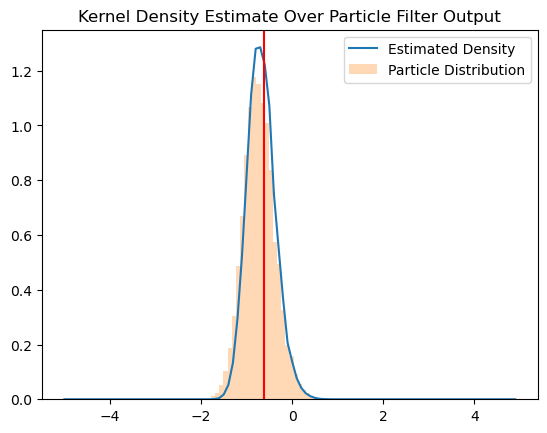

In [149]:
# Since the particles are discrete, we can do kernel density estimation with the weights.
kde = ss.gaussian_kde(x_samples[:,tt], weights=weights[:,tt], bw_method='silverman')
x_grid = np.arange(-5, 5, 0.1)
pdf_values = kde.pdf(x_grid)
plt.plot(x_grid, pdf_values, label='Estimated Density')
plt.title('Kernel Density Estimate Over Particle Filter Output')
plt.hist(x_samples[:,tt], bins=30, density=True, alpha=0.3, label='Particle Distribution')
plt.axvline(x=x[tt], color="red")
plt.legend()
plt.show()